# Open Food Facts Course Project - Cleaning, manipulating and visualizing

## First of all, be sure to have a copy of the *OpenFoodFacts.tsv* in a subdirectory named data, otherwise this Notebook won't work.

let's import usefull libraries for the project and make matplolib displaying graphs inline the Notebook.

In [1]:
from os import path # For filepath manipulation
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plot
%matplotlib inline

import seaborn

import re

pd.set_option("display.max_column",None)


Next step will be to load the Open Food Facts CSV file, which in fact is a TSV file (Cells are separated with tabs).
Loading this file will take a consequent amount of time, as the file is 1Gb big. First thing to do will be to perform some cleanup and removal of useless data, and save the result as a new CSV file.

This new CSV file will be used as datasource in this Notebook using the first **MAX_ENTRY_TO_LOAD** rows while coding.

**Don't forget to set MAX_ENTRY_TO_LOAD = None when coding is finished.** Otherwise, only a subset of the data will be processed.

* Note that this Notebook checks if the cleaned Datafile exists and create it otherwise. This process relies on three functions: First one will load the original TSV file, the second one will cleanup the orignal data and the third one will dump the cleand data into a new CSV file.

The following global constant can be adapted to suit your needs

In [2]:
# Filename of the original TSV file
ORIGINAL_TSV_FILENAME = path.join('data','OpenFoodFacts.tsv')

# Filename of the cleaned data build in this Notebook
CLEANED_CSV_FILENAME = path.join('data','OpenFoodFacts-cleaned.csv')

# If set to true, the original data file loading process is forced, event if the
# cleaned CSV file exists. Should be set to **True** when coding is finished
FORCE_LOAD_ORIGINAL_FILE = True # PRoduction value = True

# Maximum NaN percentage accepted in a column. If above, the column is dropped.
MAX_NAN_PERCENT_VALUE = 80

# Number of rows loaded from cleaned CSV file. Usefull while coding, this value should be
# set ton **None** when coding is finished.
MAX_ENTRY_TO_LOAD = None # Production value = None

# List of columns that will be removed from the Dataset (useless one)
COLUMNS_TO_DROP = [
    'creator', 'brands', 'brands_tags', 'countries',
    'countries_tags', 'additives', 'additives_tags', 'categories_tags', 'states',
    'states_en', 'states_tags', 'url', 'quantity', 'packaging_tags', 'packaging',
    'created_t', 'last_modified_t', 'pnns_groups_1', 'pnns_groups_2', 'image_url',
    'image_small_url', 'code', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'
]


## A. Importing and cleaning the data

Importing the datasource is done using Pandas **read_csv** method, using parameter **sep="\t"** as the content of the file is a tabulation spearated CSV file.

* Note that I've set the **low_memory** option to False in order to avoid warnings when loading the file. Number of columns is quite important and the process to determine the column dtype is too consuming*


### Some function definitions

#### Data loading function.

In [3]:
def loadOriginalTsvFile(filename):
    print("Loading data from file",ORIGINAL_TSV_FILENAME)
    print("Please wait...")
    df = pd.read_csv(ORIGINAL_TSV_FILENAME,sep="\t",low_memory=False, dtype='unicode')
    print("Loading process terminated.")
    return df


#### Function to dump the cleaned data into a new CSV file

In [4]:
def dumpCleanedCsvFile(df,filename):
    print("Dumping the cleaned Dataframe into file",CLEANED_CSV_FILENAME)
    print("Please wait...")
    df.to_csv(CLEANED_CSV_FILENAME)
    print("Dumping process terminated")


#### Cleanup function that process the Dataframe returned by the **loadOriginalTsvFile()** function

This function will perform cleanup actions on the whole dataset. Further in this Notebook, more cleaning actions will come while we discover the content of the Open Food Facts database.

Here is a list of the cleaning actions done here:

* Drop unused column defined in the global parameter COLUMNS_TO_DROP
* Drop columns where the percentage of null values is above MAX_NAN_PERCENT_VALUE
* Drop rows where **product_name** or **countries_en** column are empty
* Drop rows with duplicates in 'product_name' column

In [5]:
def cleanOriginalData(df):

    print("Cleaning the dataframe")
    print("Please wait...")
    # Drop unused columns
    df.drop(COLUMNS_TO_DROP,axis = 1,inplace=True)
    
    # Drop columns where percentage of NaN values is too high
    df = df.dropna(axis=1, thresh= len(df)*(1 - MAX_NAN_PERCENT_VALUE / 100), how='all') 
    
    # Drop rows with empty product_name or countries_en
    df = df[np.logical_and(
        np.logical_not(df['product_name'].isnull()),
        np.logical_not(df['countries_en'].isnull())
    )]
    
    # Drop duplicated rows in column product_name
    df.drop_duplicates(subset=['product_name'],inplace=True)

    print("Cleaning process terminated")
    
    return df

    

### Loading process

Now that our loading functions are defined, put some logic here to avoid long time processing while coding.

**Do not forget to set the global constant to Production values when coding is finished**

In [6]:
if (FORCE_LOAD_ORIGINAL_FILE == True) or path.exists(CLEANED_CSV_FILENAME) == False:
    df = loadOriginalTsvFile(ORIGINAL_TSV_FILENAME)
    df = cleanOriginalData(df)
    dumpCleanedCsvFile(df, CLEANED_CSV_FILENAME)
else:
    print("Cleaned CSV file found. Original data file processing is skipped")

    
if MAX_ENTRY_TO_LOAD != None:
    print("Loading the first",MAX_ENTRY_TO_LOAD,"rows from ",CLEANED_CSV_FILENAME)
else:
    print("Loading data from ",CLEANED_CSV_FILENAME)

print("Please wait...")
df = pd.read_csv(CLEANED_CSV_FILENAME,low_memory=False, nrows=MAX_ENTRY_TO_LOAD, index_col=0)
print("Dataframe loaded")

print('Number of rows   :',format(df.shape[0]))
print('Number of columns:',format(df.shape[1]))


Loading data from file data/OpenFoodFacts.tsv
Please wait...
Loading process terminated.
Cleaning the dataframe
Please wait...
Cleaning process terminated
Dumping the cleaned Dataframe into file data/OpenFoodFacts-cleaned.csv
Please wait...
Dumping process terminated
Loading data from  data/OpenFoodFacts-cleaned.csv
Please wait...
Dataframe loaded
Number of rows   : 249065
Number of columns: 30


### Cleaning process

Now that we've loaded a *partially* cleaned dataframe, let's explore it and perform some more clean up.

First, we can ensure that we do not have any duplicated lines. Removed them otherwise.

In [7]:
duplicated_lines = df.duplicated().sum()

if duplicated_lines == 0:
    print("No duplicated lines found")
else:
    print("Duplicated lines found:",duplicated_lines)
    print("Removing duplicates...")
    df.drop_duplicates(inplace=True)
    print("Done")


No duplicated lines found


Ensure that we do not have duplicated values in the **product_name** columns and set it as Dataframe index

In [8]:
if 'product_name' in df.columns:
    if df['product_name'].duplicated().sum() == 0:
        print("There is no duplicated values in 'product_name' column. Set it as Dataframe index")
        df.set_index('product_name', inplace=True)
    else:
        print("WARNING: Duplicated values detected in 'product_name' column. Aborting Notebook.")
        exit(1)
else:
    print("Dataframe already indexed by 'product_name'")

There is no duplicated values in 'product_name' column. Set it as Dataframe index


#### Convert date and time columns into DateTime Pandas object, for smarter time manipulations.

During the first **to_datetime()** run, I've found values that was not convertible to a Datetime object. For example, one of the row contains value **Dia,Sogeres** in its **created_datetime** cell. Solution is to set the *unparsable* datetime strings to NaT using **error=coerce** paramter in **to_datetime()** call, and then fill NaT value with **fillna()** function using **ffill** method.

In [9]:
df['created_datetime'] = pd.to_datetime(df['created_datetime'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['created_datetime'].fillna(method = 'ffill', inplace = True)

df['last_modified_datetime'] = pd.to_datetime(df['last_modified_datetime'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['last_modified_datetime'].fillna(method = 'ffill', inplace = True)


#### Parse countries_en entries to get *usable* data

**countries_en** column is a very special one as it contains the different countries where the product is produced as a comma separated string values. Consequence, this column contains 642 unique entries, which is far much more than the number of countries existing in the world :-) Not very usable for data analysis.


In [10]:
print("Number of unique entries in 'countries_en'",len(df.countries_en.unique()))

Number of unique entries in 'countries_en' 641


So, what can we do ?

The approach I've choosen is to *split* comma separated strings into arrays, using the **str.split()** function, and then, for every arrays, I do apply the **Panda.Series** method on it to convert them into **Series**, which by consequence will give me a Dataframe with columns containing the splitted strings.  

To do so, I do run the **str.split()** function on the df['countries_en'] serie to get a serie of arrays, use the **apply()** method to run **pd.Series** on each array, and finally run the **stack()** method to transform the serie of arrays into a Dataframe.

* Note: The stack method introduces a two level index. Using the **Dataframe.droplevel()** method on the second index (indice = 1) will duplicate entries in the first index and provide a single level index Dataframe. This is exactly what I'm looking for.

Looking forward into the Open Food Facts data, we can identify some other columns containing comma separated strings like 'countries_en' ('ingredient_text' for example). For that reason, I've decided to write a generic function that implement this String Splitting algorythm and returns an *expanded* Series.



In [11]:

def splitStringSeriesToDataframe(data, column_name, sep = ','):
    # Split strings using sep as separator
    temp = data[column_name].str.split(sep)
    
    # apply pd.Series constructor on arrays. This will return a Dataframe
    temp = temp.apply(pd.Series,1)
    
    # stack Dataframe
    temp = temp.stack()
    
    # Drop second level index created by the previous stack() call
    temp = temp.droplevel(1) # Second index = indice[1]
    
    # Rename the index
    temp.name = column_name + '_splitted'
    
    return temp


countries = splitStringSeriesToDataframe(df,'countries_en')


Let's have a look at the new Dataframe obtained:

In [12]:
countries.describe()

count            254947
unique              202
top       United States
freq             115895
Name: countries_en_splitted, dtype: object

The result is far more better as we get 202 unique entries. It's still a bit more than the total number of countries in the world, but better than the 641 entries we get before.

Looking deeper in this country list, I've found some entries encoded like **<2_char_country_code>:country_name** :

In [13]:
countries[countries.str.contains(':')].unique()

array(['fr:Quebec', 'fr:Angleterre', 'fr:Grande-bretagne',
       'fr:Deutschland', 'fr:Frankreich', 'fr:Spanien', 'fr:Marseille-5',
       'en:fresh-foods', 'en:dairies', 'fr:Alemania', 'fr:Mauricio',
       'fr:Reino-unido', 'fr:Франция',
       'fr:Bourgogne-aube-nogent-sur-seine', 'fr:Puyricard', 'fr:Ecosse',
       'fr:Schweiz', 'fr:Nederland', 'fr:Irland', 'nl:Belgien',
       'nl:Deutschland', 'nl:Frankreich', 'nl:Schweiz'], dtype=object)

Thing to do will be to manipulate the **countries_en** dataframe column with a regex expression to remove the 2 char country code.

In [14]:
df['countries_en'] = df['countries_en'].apply(lambda x: re.sub('[a-z]*:','',x))

countries = splitStringSeriesToDataframe(df,'countries_en')

print("Number of unique countries found in this dataset:",len(countries.unique()))

Number of unique countries found in this dataset: 195


For sure, the data present in the dataset is very bad, and there's a lot more to do on this **countries_en** column: Some of the countries appears in different languages, some of them looks more like categories instead of coiuntries (en:fresh-foods), others are a city names (fr:Marseille-5).

It's now time to manipulate the data and find answers to three questions we may have about the data in this dataset.

## B. Manipulating the data



### Question 1: What is the ratio of null value per column in our Dataframe ?
We've already cleaned up our Dataframe removing columns where the null values over total lines is above *MAX_NAN_PERCENT_VALUE* percents, and *last_modified_datetime* and *created_datetime* null values have been replaced with the *fillna()* function. The 0% null value in those two last column are not relevant.

Let's draw a graph showing the null value ratio for each remaining column. This will help us chosing which columns may be used for data analysis. The more null value, the less intersting is the column.

First, let's store the total number of lines in the Dataframe using the *shape* attribute, and use this value to calculate the percentage of null values per column.

We will use the combination of *isnull()* and *sum()* method to retrieve a *Series* containing the number of null cells per Dataframe column. Then we'll divide each values per the *total_lines* and multiply result by 100 to obtain percentage

In [15]:
# Get number of Dataframe lines
total_lines = df.shape[0]

# Sum up the number of null values in each column
null_ratio = df.isnull().sum()

# Transform those values into percentage
null_ratio_as_percent = null_ratio/total_lines * 100

# Convert Series to Dataframe and set a smart column name
null_ratio_as_percent = null_ratio_as_percent.to_frame()
null_ratio_as_percent.columns=['% of null values']


Now, we sort the Dataframe using the calculated percentage values and draw a Horizontal Bar graph.

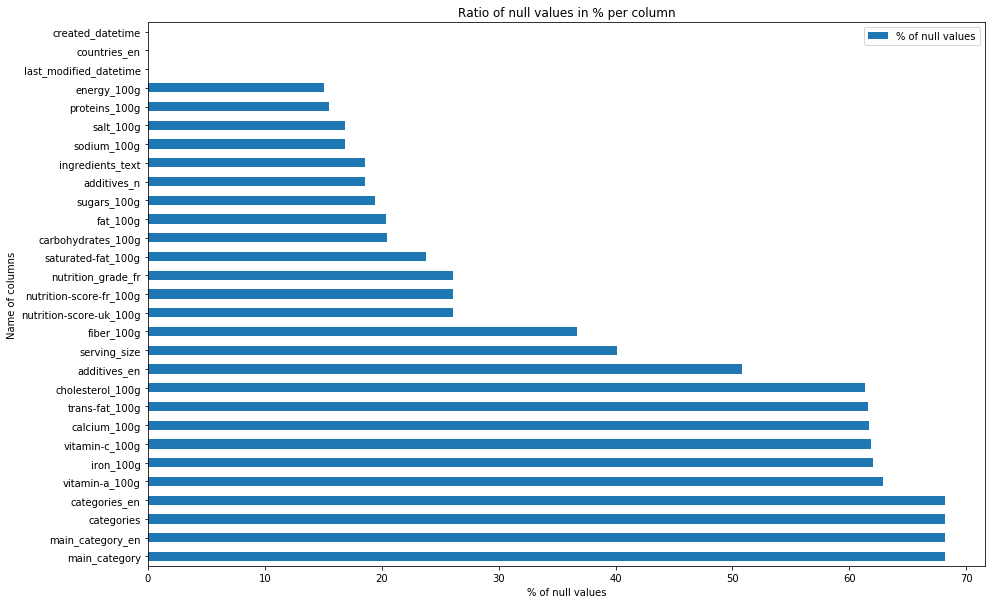

In [16]:
# Graph our sorted data
null_ratio_as_percent.sort_values('% of null values', ascending=False).plot.barh(figsize=(15,10))

# Set and some smart info to the Graph
plot.legend(loc = 'upper right')
plot.xlabel('% of null values')
plot.ylabel('Name of columns')
plot.title('Ratio of null values in % per column')

# Show Graph
plot.show()


As we can see on the Graph, a very few columns did contains at least 50% of non null cells. We'll have to consider this in the next chapter of this Notebook, when playing with this Dataframe.

### Question 2: What are the top 10 contries with the highest mean of energy per 100g ?

So, first question we may have, in order to use our new *splitStringSeriesToDataframe()* function, would be to identify the top 10 countries having the most energetic food. This could be done by analyzing the *energy_100g* column and sum values per country.

First we set our Dataframe index to the *energy_100g* column, and call our *split* function on the *countries_en* column. The result will be a Dataframe that will be reindexed, grouped, sorted and used in a Bar plot.

Do not forget to fill empty values with 0 in resulting Dataframe.

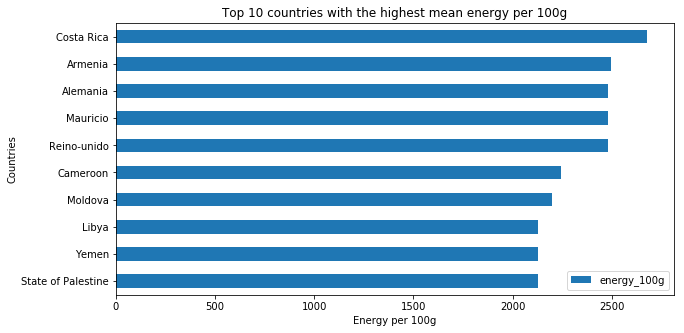

In [17]:
energy = splitStringSeriesToDataframe(df.set_index('energy_100g'),'countries_en')

energy = energy.to_frame().reset_index().set_index('countries_en_splitted')

energy_mean = energy.groupby('countries_en_splitted').mean().sort_values(by = ['energy_100g'],ascending = False).fillna(0)

energy_mean.head(10).sort_values(by = ['energy_100g']).plot.barh(figsize=(10,5))
plot.legend(loc = 'lower right')
plot.ylabel('Countries')
plot.xlabel('Energy per 100g')
plot.title('Top 10 countries with the highest mean energy per 100g')
plot.show()

The above graph is a bit surprising, the top most countries seems to be invalid. Looking further in details, we are facing a simple statistic problem. Some of the countries do not have many entries, wich by consequence makes the energy/100g mean for those countries not really relevant.

If we look at the number of *energy_100g* entries per countries in our Dataset, we found that 75% of countries contains less than 17 entries, and 50 % of them less than 3. That's the reason why our previous graph was so surprising.


In [18]:
energy.groupby('countries_en_splitted').count().describe()

,energy_100g
count,195.000000
mean,1110.435897
std,9882.381963
min,0.000000
25%,1.000000
50%,3.000000
75%,17.000000
max,114582.000000


Let's redraw this graph by excluding countries where the number of entries is too small (number of entries < 200)

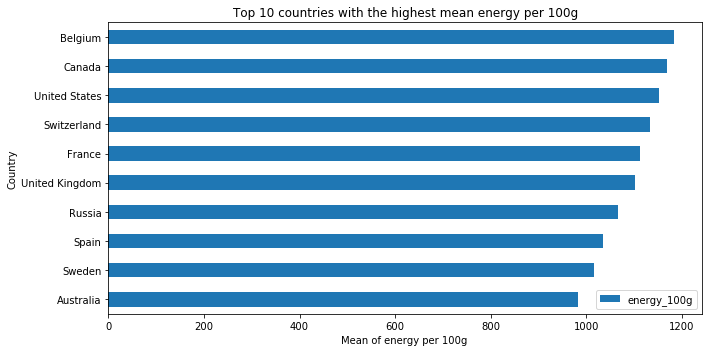

In [19]:
energy_count = energy.groupby('countries_en_splitted').count()
energy_mean = energy.groupby('countries_en_splitted').mean()

energy_mean[energy_count['energy_100g'] > 200].sort_values(by = ['energy_100g']).head(10).plot.barh(figsize=(10, 5))

plot.title("Top 10 countries with the highest mean energy per 100g")
plot.xlabel("Mean of energy per 100g ")
plot.ylabel("Country")
plot.legend(loc='lower right')

# Display graph
plot.tight_layout()
plot.show()




### Question 3: Is there any correlation between sugar and salt ?

Sugar and salt are used very often in bad food, they are used to make products being addictive to consumers. The more sugar you have in a product, the more you should put salt in it in ordrer to make consumers addict to your product.

If that's true, we should find a correlation between sugar and salt. Let's use **seaborn.pairplot** to answer this question.

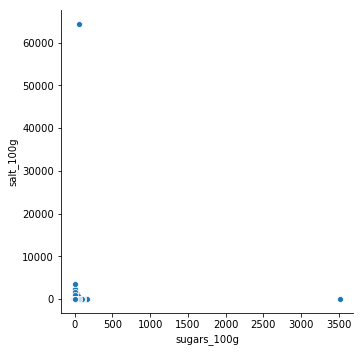

In [20]:
sugar_and_salt = df.reset_index()[['sugars_100g','salt_100g']].fillna(0)

sns.pairplot(sugar_and_salt,x_vars='sugars_100g',y_vars='salt_100g',height=5)
plot.show()

This first graph shows that there is outstanding values in the Dataframe, which obviously should be wrong values. Using the **describe()** method, we can confirm that some of the values should be considered as bad one:
* Negative values are not coherent
* 64'000 g of salt per 100g of food is impossible

My approach: Remove negative values and all the values that are third more important than the mean value

In [21]:
sugar_and_salt.describe()

,sugars_100g,salt_100g
count,249065.000000,249065.000000
mean,12.853372,1.634025
std,20.961988,129.618056
min,-6.250000,0.000000
25%,0.000000,0.000000
50%,3.330000,0.241300
75%,17.120000,1.148080
max,3520.000000,64312.800000


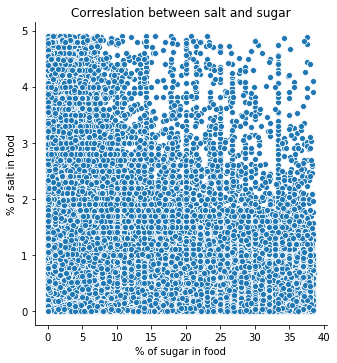

In [22]:
sugar_and_salt = df.reset_index()[['sugars_100g','salt_100g','countries_en']].fillna(0)

sugar_up_limit = sugar_and_salt['sugars_100g'].mean() * 3
salt_up_limit = sugar_and_salt['salt_100g'].mean() * 3

filter = np.logical_and.reduce(
    [
        sugar_and_salt['sugars_100g'] >= 0,
        sugar_and_salt['salt_100g'] >= 0,
        sugar_and_salt['sugars_100g'] < sugar_up_limit,
        sugar_and_salt['salt_100g'] < salt_up_limit,
    ]
)
sugar_and_salt = sugar_and_salt[filter]
sugar_and_salt.describe()

sns.pairplot(sugar_and_salt,x_vars='sugars_100g',y_vars='salt_100g',height=5)
plot.xlabel("% of sugar in food")
plot.ylabel("% of salt in food")
plot.title("Correslation between salt and sugar")

plot.show()



Obvisously, according to the previous graph, we can not conclude on any correlation between the quantity of salt and sugars in food.

## C. Text data

We will now try to find out the five most common ingredients used in products. 
Again, we will use the *splitStringSeriesToDataframe()* function we've defined above to split the *ingredients_text* column into a dataframe.

Based on this new dataframe, we will re-index it using the *ingrediens_text_splitted* column, use this column as *DataFrame.groupby()* function parameter, and use the *count()* method to sum up the number of lines with identical ingredients. Sorting the dataframe by this count value and grabbing the first 5 lines will give us the top most five ingredients used in food.



In [23]:
# Split column and build a Dataframe with our smart function
ingredients = splitStringSeriesToDataframe(df,'ingredients_text').to_frame()


In [24]:
# Set splitted values as the DataFrame index
ingredients_grouped = ingredients.reset_index().set_index('ingredients_text_splitted')

# Group by the ingredients column, use the count() function
ingredients_grouped = ingredients_grouped.groupby('ingredients_text_splitted').count()

# sort values in descending order
ingredients_grouped = ingredients_grouped.sort_values(by = ['product_name'],ascending = False)

# Print top five
print("Top five ingredients used in food")
ingredients_grouped.head(5)

Top five ingredients used in food


,product_name
ingredients_text_splitted,
salt,57346
sugar,36335
water,32406
sel,32179
sucre,21690


Again, this dataset is so bad that we find out french and english names for ingredients.

How boring is that datasource........

In [25]:
# Reset index
ingredients_grouped = ingredients.reset_index()

# perform some cleanup on data using a function
def transform(s):
    s=s.str.lower()  # lower all characters for better grouping results
    s=s.str.replace('sel','salt')
    s=s.str.replace('sucre','sugar')
    s=s.str.replace('eau','water')
    s=s.str.replace(')','') # remove parenthesis
    s=s.str.replace('(','') # remove parenthesis
    s=s.str.replace(' ','') # remove all spaces
    s=s.str.replace('seasalt','salt')
    return s
ingredients_grouped['ingredients_translated'] = transform(ingredients_grouped['ingredients_text_splitted'])

# set new translated column as index
ingredients_grouped = ingredients_grouped.reset_index().set_index('ingredients_translated')

# Group by the ingredients column, use the count() function
ingredients_grouped = ingredients_grouped.groupby('ingredients_translated').count()

# sort values in descending order
ingredients_grouped = ingredients_grouped.sort_values(by = ['product_name'],ascending = False)

# Print top 15 to ensure our result does not mix french and english ingredient names
#
ingredients_grouped[['product_name']].head(15)


,product_name
ingredients_translated,
salt,110656
sugar,72547
water,65271
citricacid,19178
dextrose,14568
niacin,13634
riboflavin,12384
cornsyrup,12216
folicacid,11439


In [26]:
# Ok, looks good now. Let's print our top five ingredients
print("Top five ingredients used in food")
ingredients_grouped[['product_name']].head(5)

Top five ingredients used in food


,product_name
ingredients_translated,
salt,110656
sugar,72547
water,65271
citricacid,19178
dextrose,14568


## D. Time-series analysis

Note that *created_datetime* and *last_modified_datetime* columns have been converted to Datetime object in the *cleaning* section of this Notebook, and null values have been filled in using the *fillna()* method. We can assume that there is no null values in those two columns.


### Analyze the mean time difference between created_datetime and last_modified_datetime

Let's build a Dataframe containing those two columns only.

In [27]:
# Build a new Dataframe
df_time = df[['created_datetime','last_modified_datetime']].copy()

# Perform some sanity check
if df_time[df_time['last_modified_datetime'] < df_time['created_datetime']].shape[0] > 0:
    print("WARNING: last_modified_datetime prior to created_datetime found. Notebook aborting")
    exit(1)
df_time.describe()

,created_datetime,last_modified_datetime
count,249065,249065
unique,173138,166924
top,2017-03-09 10:37:09,2015-08-09 17:35:42
freq,18,26
first,2012-01-31 14:43:58,2012-03-21 22:15:32
last,2017-09-18 00:45:56,2017-09-18 01:01:03


Now calculate the time difference between those two values and use the *describe()* method to grab some usefull informations

In [28]:
df_time_with_difference = df_time.assign(difference_datetime = df_time['last_modified_datetime'] - df_time['created_datetime'])
df_time_with_difference.describe()


,difference_datetime
count,249065
mean,117 days 08:23:55.937570
std,295 days 02:43:21.934136
min,0 days 00:00:00
25%,0 days 00:00:00
50%,0 days 00:00:02
75%,18 days 21:40:24
max,2021 days 10:24:24


As we can see, at least 50% of the entries haven't been update since their creation (or at least less than a few seconds after being created), and the mean time is around 117 days.

We can conclude that a very few of the product entries are modified long after they've been created in the database.

Let's calculate the ratio of entries where the *difference_datetime* value is more that 1000 days

In [29]:
# df_time_with_difference.sort_values('difference_datetime', ascending=False)
total_lines = df_time_with_difference.shape[0]
difference_above_50_days = df_time_with_difference[df_time_with_difference['difference_datetime'] > '1000 days'].shape[0]

print("Ratio of entries where difference between create_datetime and last_modified_datetime is more than 1000 days:",difference_above_50_days / total_lines * 100,"%")

Ratio of entries where difference between create_datetime and last_modified_datetime is more than 1000 days: 3.33366791801337 %


### Analyze the total number of items created each month over the full timeline of the data.

To do so, we will have reindex our Dataframe using the *created_datetime* column (this will be done on a copy of our base Dataframe), and use the *resample()* method with 'MS' string as parameter, which correspond to *Month Start* value, to get a resampled value of our Dataframe using 1 month buckets. The *resample()* method will be used in conjonction with the *count()* method to get the number of items created per time bucket.


In [30]:
# Build a new Dataframe
df_created_time = df[['created_datetime']].copy().reset_index().set_index('created_datetime')
df_created_time = df_created_time.sort_values('created_datetime').resample('MS').count()
df_created_time.head(3)

,product_name
created_datetime,
2012-01-01,1
2012-02-01,9
2012-03-01,123


This 1 month time bucket Dataframe will be represented using a basic ploting graph, having 3 horizontal lines: minimum value in green, maximum value in blue, and mean value in red, and two vertical ones: The red one marks the 1st of February 2017, the green one marks the 1st of April 2017.

This graph immediately demonstrate that most of the product entries have been made between the 1st of February 2017 and the 31st of March 2017.

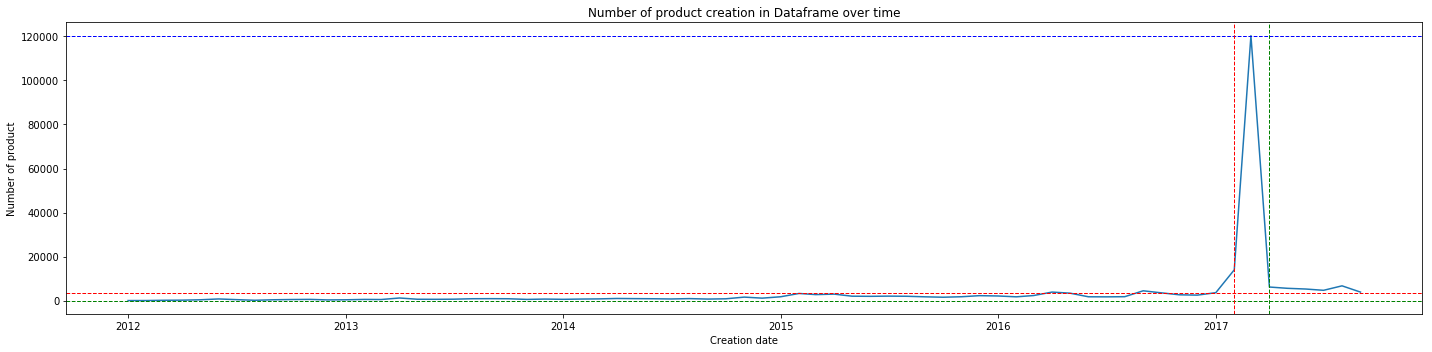

In [31]:
# set some option for our graph.
fig, ax = plot.subplots(figsize=(20, 5))

# create the plot
ax.set_title('Number of product creation in Dataframe over time')
ax.set_xlabel('Creation date')
ax.set_ylabel('Number of product')
ax.plot(df_created_time)
ax.axhline(df_created_time.mean()[0],color='r', linewidth=1, linestyle='--')
ax.axhline(df_created_time.max()[0],color='b', linewidth=1, linestyle='--')
ax.axhline(df_created_time.min()[0],color='g', linewidth=1, linestyle='--')
ax.axvline('2017-02-01',color='r', linewidth=1, linestyle='--')
ax.axvline('2017-04-01',color='g', linewidth=1, linestyle='--')

# Display graph
fig.tight_layout()
plot.show()

## E. Build a database

The question we would like to answer using an SQLite database is:
- What are the top five most energetic product which belongs to the *Biscuits* category ?

To achieve that goal, we will:
- Create (or open) a database connection to an SQLite file (using sqlite3 lib)
- Create a cursor object to interact with the database
- Restrict data from DataFrame to MAX_DB_LINES lines and COLUMN_LIST columns
- Create a *foodfacts* table with *product_name* as primary key
- Load data into this table, without the *categories* column
- Create a *product_categories* table which contains two columns: the *product_name* and its *category*
- As *category* in our Dataframe may be multivaluated, we use our magic function *splitStringSeriesToDataframe* to split multivaluated cells
- Load the previous result into the *product_categories* table
- Run an SQL query joining those two tables, filtering by *category = 'Biscuits'*, sort descending and limit result to 5.


That's it :-)


In [32]:
# Import sqlite3 library
import sqlite3

# Establish a connection to our database
db = sqlite3.connect("data/my_database.db")

# Get a cursor object on our database to perform some SQL queries out from Pandas
cursor = db.cursor()



In [33]:
# Max number of our Dataframe entries loaded into our DB
MAX_DB_LINES=9000

# list of columns kept from dataframe
COLUMN_LIST = ['categories','energy_100g','fat_100g','sugars_100g','proteins_100g','salt_100g']
limited_df = df.head(MAX_DB_LINES)[COLUMN_LIST]

# Drop tables for cleanup (this will ensure that Notebook could be ruan several times)
cursor.execute("DROP TABLE IF EXISTS foodfacts")

# Create 'foodfacts' table using 'product_name' as a primary key
create_query = "CREATE TABLE foodfacts (product_name VARCHAR, " + ' VARCHAR, '.join(COLUMN_LIST[1:]) + " VARCHAR, PRIMARY KEY(product_name))"

print("Query used to create 'foodfacts' table:",create_query)
cursor.execute(create_query)

# Load our Datafram into our SQL DB removing the 'categories' column
limited_df.drop(['categories'],axis=1).to_sql(name='foodfacts', con=db, if_exists='append', index=True)




Query used to create 'foodfacts' table: CREATE TABLE foodfacts (product_name VARCHAR, energy_100g VARCHAR, fat_100g VARCHAR, sugars_100g VARCHAR, proteins_100g VARCHAR, salt_100g VARCHAR, PRIMARY KEY(product_name))


In [34]:
# Drop tables for cleanup (this will ensure that Notebook could be ran several times)
cursor.execute("DROP TABLE IF EXISTS product_categories")

# Build a 'category' dict
categories = splitStringSeriesToDataframe(limited_df,'categories').to_frame()
categories.to_sql(name='product_categories', con=db, index = True)

In [35]:
# Now, select the top five most energetic product which are in category 'Biscuits'
# Display energy value as energy/kg

# defining our helper function for running queries (taken from the courses)
def run_query(query):
    return pd.read_sql_query(query,db)


print("Energy/kg per product which belongs to the 'Bisuits' category")
run_query("""
SELECT
  F.product_name AS product,
  F.energy_100g AS energy_per_kg
FROM foodfacts AS F
INNER JOIN product_categories AS C ON (F.product_name = C.product_name)
WHERE 1=1
AND C.categories_splitted = 'Biscuits'
ORDER BY energy_per_kg DESC LIMIT 5
          """).set_index('product')

Energy/kg per product which belongs to the 'Bisuits' category


,energy_per_kg
product,
Chocolate Chunk Crispy Cookies - Dark Chocolate Pecan,2269.0
Milano Distinctive Cookies,2260.0
Chocolate Chunk Milk Chocolate Macadamia Crispy Cookies,2230.0
Milano Dark Chocolate,2210.0
Milano Orange Flavored Chocolate,2180.0


## F. Finding correlations

### Is there a correlation between fat, sugar, proteins and the nutrition score ?

For that purpose, we'll build a correlation matrix from my dataframe, reduced to 4 columns: sugars_100g, fat_100g, proteins_100g and nutrition-score-fr_100g

We will then represent this matrix using an seaborn heatmap graph.

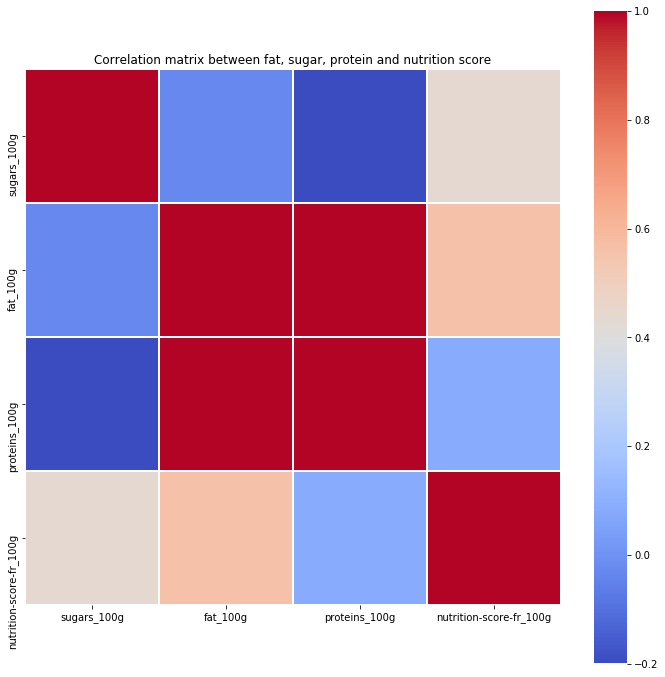

In [36]:
# use the dr.corr method to get our correlation matrix
matrix = df[['sugars_100g','fat_100g','proteins_100g','nutrition-score-fr_100g']].corr()

# set some option for our heatmap graph.
f, ax = plot.subplots(figsize=(12, 12))

# define graph title
ax.set_title('Correlation matrix between fat, sugar, protein and nutrition score')

# draw the heatmap
sns.heatmap(matrix, square=True, linewidths=1, cmap="coolwarm")

# Show the graph
fig.tight_layout()
plot.show()

#### What can we say from the above Matrix ?

Well, not surpisingly, nutrition score is mostly correlated with fat. Fat is the best energy container we have in nature. Without fat, life is not possible (think about lipids that protect our cells).

Protein seems to be inversly proportionnal to nutrition score, same with sugar (T-Bone steack is not really tasting with chocolate sauce :-) )
